In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edbo
import pandas as pd
from gpytorch.priors import GammaPrior
from edbo.pd_utils import to_torch
import copy
from edbo import to_torch

In [2]:
from data_anal_tools import populate_design_space, standardize_domain

In [44]:
a = 'parent/caonima/nimabi.ch'

In [45]:
b = list(a)[::-1]
ind = np.where(np.array(b) == '/')[0][1]

In [47]:
a[:-ind]

'parent/'

In [52]:
a = [1,2,3,4]

In [53]:
print('caonima [%f, %f, %f, %f]' %(a[]))

TypeError: must be real number, not list

In [14]:
# define design space
VARIABLES = {
    # (<start>, <end>, <step>)
    'temperature': (-10, 30, 2), # C
    'dosing_duration': (0, 60, 5), # mins
    'NaBH4': (0.1, 2, 0.1), # equiv  
    'SM': (1, 10, 1) # mM
}

arr_list = []
name_list = []

for variable, (start, end, increment) in VARIABLES.items():
    # arange excludes the last value, so add the increment to it to ensure it's included
    arr_list.append(np.arange(start, end + increment, increment))
    name_list.append(variable)

# not standardized
domain = pd.DataFrame(populate_design_space(arr_list, name_list))

#standardize
std_domain = standardize_domain(domain, VARIABLES)

# bo params
target 				 = 'yields' # give a name to the DataFrame column
acquisition_function = 'EI'
init_method          = 'rand'
batch_size 			 = 1 # number of exps proposed during each iteration
lengthscale_prior    = [GammaPrior(1.2, 1.1), 0.2] # GP prior and initial value
noise_prior          = [GammaPrior(1.2, 1.1), 0.2]

# folder info
dir_to_watch         = '.'
files_to_watch       = ['']

# exp info
round_               = 0
total_exps           = 2

In [16]:
# init bo
bo = edbo.bro.BO(results_path=None, 
                 domain=std_domain, 
                 target=target, 
                 acquisition_function=acquisition_function,
                 init_method=init_method,
                 lengthscale_prior=lengthscale_prior, 
                 noise_prior=noise_prior, 
                 batch_size=batch_size, 
                 fast_comp=False, # not using gpytorch to accelerate computation
                 computational_objective=None) 

# propose the first experiment 
_ = bo.init_sample(append=False)

In [17]:
bo.proposed_experiments.index.values

array([21385])

In [18]:
domain.iloc[bo.proposed_experiments.index.values]

,temperature,dosing_duration,NaBH4,SM
21385,6,10,1.9,6


In [15]:
for i in arr_list: 
    print(len(i))

21
13
20
10


In [25]:
def minmax(x): 
    return (x - min(x)) / (max(x) - min(x))

d = domain.to_numpy()
for i in range(d.shape[-1]): 
    d[:, i] = minmax(d[:, i])

In [35]:
std_domain = {}
for i, (var, (_, _, _)) in enumerate(VARIABLES.items()):
    std_domain[var] = d[:, i]
std_domain = pd.DataFrame(std_domain)

In [36]:
std_domain

,temperature,dosing_duration,NaBH4,SM
0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.111111
2,0.0,0.0,0.0,0.222222
3,0.0,0.0,0.0,0.333333
4,0.0,0.0,0.0,0.444444
...,...,...,...,...
256195,1.0,1.0,1.0,0.555556
256196,1.0,1.0,1.0,0.666667
256197,1.0,1.0,1.0,0.777778
256198,1.0,1.0,1.0,0.888889


In [37]:
domain

,temperature,dosing_duration,NaBH4,SM
0,-10,0,0.1,1
1,-10,0,0.1,2
2,-10,0,0.1,3
3,-10,0,0.1,4
4,-10,0,0.1,5
...,...,...,...,...
256195,30,60,2.0,6
256196,30,60,2.0,7
256197,30,60,2.0,8
256198,30,60,2.0,9


In [2]:
from data_anal_tools import appendResToEdbo

In [3]:
def plot(bo): 
    mean = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain)) # gp posterior mean
    std = np.sqrt(bo.model.variance(bo.obj.domain)) * bo.obj.scaler.std * 2  # gp posterior std
    
    target = bo.obj.target
    current_res = (bo.obj.scaler.unstandardize_target(bo.obj.results, target)).to_numpy()
#     next_res = bo.obj.get_results(bo.proposed_experiments).to_numpy() # use computational model to simulate results
    
    # existing results and next experiments and their results
    plt.figure(figsize=(8, 8))
    
    plt.subplot(211)
    plt.plot(x, y, label='True function')
#     plt.plot(bo.obj.domain.to_numpy()[:, 0], mean, label='GP mean')
    plt.fill_between(x.flatten(), mean-std, mean+std, alpha=0.4)

    plt.subplot(212)
    plt.plot(x, y, label='True function')
    plt.scatter(current_res[:, 0], current_res[:, 1],  color='k', label='known experiments')
#     plt.scatter(next_res[:, 0], next_res[:, 1],  color='r', label='next experiments')

    plt.legend()
    plt.show()
    
    return next_res[0][1][0]

In [10]:
def f(X):
    return -np.sin(3*X) - X**2 + 0.7*X

x = np.arange(-1, 5, 1)
y = np.arange(-1, 2, 1)
z = np.arange(-1, 2, 1)
# y = f(x)

# plt.plot(x, y)
# plt.show()
X = {'X': x}
encoding = {'X': 'numeric'}

In [11]:
y.shape

(3,)

In [12]:
# need to convert the search space into a dataframe object
X = {'X': x, 'Y': y, 'Z': z}
encoding = {'X': 'numeric', 'Y': 'numeric', 'Z': 'numeric'}

In [13]:
# init bo_expess
bo = edbo.BO_express(reaction_components=X,
                encoding=encoding,
                batch_size=1,
                init_method='rand',
                acquisition_function='EI',
                target='f(x)')

In [14]:
bo.reaction.base_data

,X_index,X,Y_index,Y,Z_index,Z
0,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,0,0
2,-1,-1,-1,-1,1,1
3,-1,-1,0,0,-1,-1
4,-1,-1,0,0,0,0
5,-1,-1,0,0,1,1
6,-1,-1,1,1,-1,-1
7,-1,-1,1,1,0,0
8,-1,-1,1,1,1,1
9,0,0,-1,-1,-1,-1


In [8]:
bo.obj.domain

,X,Y,Z
0,0.0,0.0,0.0
1,0.0,0.0,0.5
2,0.0,0.0,1.0
3,0.0,0.5,0.0
4,0.0,0.5,0.5
5,0.0,0.5,1.0
6,0.0,1.0,0.0
7,0.0,1.0,0.5
8,0.0,1.0,1.0
9,0.5,0.0,0.0


In [9]:
edbo.__file__

'/opt/anaconda3/envs/edbo/lib/python3.7/site-packages/edbo/__init__.py'

In [10]:
first = bo.init_sample()
first = first.to_numpy()[0][0]

In [11]:
first_res = f(first)

In [12]:
appendResToEdbo(bo, first_res)

In [13]:
lol = bo.run()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2.3445601  0.29418388 2.3445632  2.6352077  2.6485775  2.6489313
 2.5569372  2.3445628  2.5569375  2.6429002  2.6487448  2.648934
 2.6429002  2.6352077  2.6429002  2.6482465  2.648904   2.6489372
 2.6487448  2.6485775  2.6487448  2.648904   2.6489356  2.648937
 2.648934   2.6489313  2.648934   2.6489372  2.648938   2.6489382
 2.6489358  2.648938   2.648938   2.6489377  2.648937   2.6489382 ]


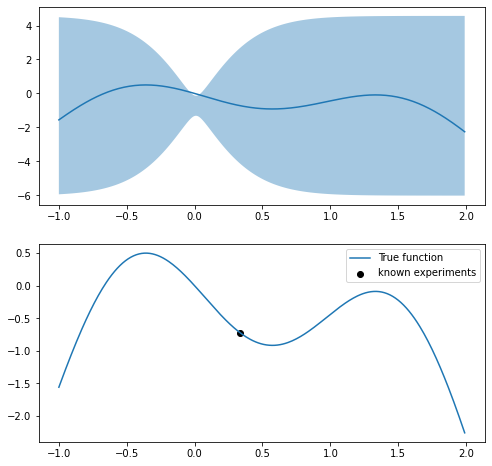

NameError: name 'next_res' is not defined

In [61]:
plot(bo)

In [50]:
bo.obj.domain.to_numpy()[:, 0]

array([0.        , 0.00334448, 0.00668896, 0.01003344, 0.01337793,
       0.01672241, 0.02006689, 0.02341137, 0.02675585, 0.03010033,
       0.03344482, 0.0367893 , 0.04013378, 0.04347826, 0.04682274,
       0.05016722, 0.05351171, 0.05685619, 0.06020067, 0.06354515,
       0.06688963, 0.07023411, 0.0735786 , 0.07692308, 0.08026756,
       0.08361204, 0.08695652, 0.090301  , 0.09364548, 0.09698997,
       0.10033445, 0.10367893, 0.10702341, 0.11036789, 0.11371237,
       0.11705686, 0.12040134, 0.12374582, 0.1270903 , 0.13043478,
       0.13377926, 0.13712375, 0.14046823, 0.14381271, 0.14715719,
       0.15050167, 0.15384615, 0.15719064, 0.16053512, 0.1638796 ,
       0.16722408, 0.17056856, 0.17391304, 0.17725753, 0.18060201,
       0.18394649, 0.18729097, 0.19063545, 0.19397993, 0.19732441,
       0.2006689 , 0.20401338, 0.20735786, 0.21070234, 0.21404682,
       0.2173913 , 0.22073579, 0.22408027, 0.22742475, 0.23076923,
       0.23411371, 0.23745819, 0.24080268, 0.24414716, 0.24749

In [114]:
VARIABLES = {
    # (<start>, <end>, <step>)
#     'residence_time': (2, 100, 5),  # 2-100 min, increment of 2min
    'temperature': (30, 150,4),
    'dppa': (1, 3, 3),
    'isoporopanol': (1, 3, 2)
}

BATCH_SIZE = 2
TARGET = 'yield'
INIT_METHOD = 'rand'
ACQUISITION_FUNCTION = 'TS'


#
# Create the experiment domain using the given start, end and step value for each variable
#

components = {}
encoding = {}

for variable, (start, end, increment) in VARIABLES.items():
    # arange excludes the last value, so add the increment to it to ensure it's included
    domain = np.linspace(start, end + increment, increment)
    components[variable] = domain
    encoding[variable] = 'numeric'


#
# Configure edbo to use our experiment domain and the given optimization functions
#

bo = edbo.BO_express(reaction_components=components,
                encoding=encoding,
                batch_size=BATCH_SIZE,
                init_method=INIT_METHOD,
                acquisition_function=ACQUISITION_FUNCTION,
                target=TARGET)


In [115]:
bo.obj.domain.columns

Index(['temperature', 'dppa', 'isoporopanol'], dtype='object')

In [118]:
for name, arr in components.items():
    print(arr)

[ 30.          71.33333333 112.66666667 154.        ]
[1.  3.5 6. ]
[1. 5.]


In [117]:
bo.obj.domain

,temperature,dppa,isoporopanol
0,0.000000,0.0,0.0
1,0.000000,0.0,1.0
2,0.000000,0.5,0.0
3,0.000000,0.5,1.0
4,0.000000,1.0,0.0
5,0.000000,1.0,1.0
6,0.333333,0.0,0.0
7,0.333333,0.0,1.0
8,0.333333,0.5,0.0
9,0.333333,0.5,1.0
